In [17]:
import numpy as np
import pandas as pd
import seaborn as sns
from warnings import filterwarnings
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

filterwarnings('ignore')
sns.set(rc={'figure.figsize':(14,9)})

In [18]:
data = pd.read_csv("bank_churn.csv")
clean_column_name = []
columns = data.columns
for i in range(len(columns)):
    clean_column_name.append(columns[i].lower())
data.columns = clean_column_name
data = data.drop(["rownumber", "customerid", "surname"], axis=1)

data.head()

,creditscore,geography,gender,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [19]:
data.columns

Index(['creditscore', 'geography', 'gender', 'age', 'tenure', 'balance',
       'numofproducts', 'hascrcard', 'isactivemember', 'estimatedsalary',
       'exited'],
      dtype='object')

In [20]:
columns.shape

(14,)

In [21]:
cleaned_data = data.copy()
cleaned_data = cleaned_data[~((cleaned_data['exited'] == 1) & (cleaned_data['numofproducts'] == 4))]
cleaned_data.shape
cleaned_data

,creditscore,geography,gender,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...
9995,771,France,Male,39,5,0.00,2,1,0,96270.64,0
9996,516,France,Male,35,10,57369.61,1,1,1,101699.77,0
9997,709,France,Female,36,7,0.00,1,0,1,42085.58,1
9998,772,Germany,Male,42,3,75075.31,2,1,0,92888.52,1


In [22]:
y = cleaned_data['exited'].values
type(y)
np.size(y)



9940

In [23]:
X = cleaned_data.iloc[:, :-1].copy()
y = cleaned_data['exited'].values
X['gender'] = X['gender'].apply(lambda x: 1 if x == "Female" else 0)
X = X.join(pd.get_dummies(data['geography']))
del X['geography']
clean_column_name = []
columns = X.columns
for i in range(len(columns)):
    clean_column_name.append(columns[i].lower())
X.columns = clean_column_name
X.head()

,creditscore,gender,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,france,germany,spain
0,619,1,42,2,0.00,1,1,1,101348.88,1,0,0
1,608,1,41,1,83807.86,1,0,1,112542.58,0,0,1
2,502,1,42,8,159660.80,3,1,0,113931.57,1,0,0
3,699,1,39,1,0.00,2,0,0,93826.63,1,0,0
4,850,1,43,2,125510.82,1,1,1,79084.10,0,0,1


En pratique, le fait de séparer l'échantillon en deux sous-ensembles, à savoir un ensemble d'entraînement et un ensemble de test, constitue déjà d'une pratique de validation de modèle. En l'occurrence, cette technique permettait de détecter un éventuel sur-apprentissage du modèle.

## Techniques de ré-échantillonnage

Pour fournir des intervalles de confiances et vérifier la stabilité des prédictions sur des potentiels futurs données, il est utile d'avoir recours à la technique de Bootstrapping, et surtout celle permettant de générer des intervalles de confiances en utilisant des sous-échantillons de l'ensemble de test (le Bootstrap offre plus de possibilités, mais ici nous l'utilisons uniquement pour déterminer la stabilité du modèle). De manière générale, un ré-échantillonnage peut se formuler par la procédure suivante :

- On dispose des ensembles $X^{\text{Train}}$ et $X^{\text{Test}}$.
- On utilise ensuite l'algorithme ci-dessous.
    - On sélectionne des sous-échantillons $U^{\text{Train}} \subset X^{\text{Train}}$ et $U^{\text{Test}} \subset X^{\text{Test}}$ aléatoires pour chaque $1 \leq j \leq B$
    - On entraîne un modèle sur $U^{\text{Train}}$
    - Une prédiction du score $S_j$ est obtenue sur $U^{\text{Test}}$

La distribution empirique $(S_j)_{1 \leq j \leq B}$ nous permet de calculer le score prédit ainsi que des intervalles de confiances associés

Au final, nous obtenons une séquence de valeurs de scores empiriques calculés sur les sous-échantillons. Cela permet donc d'offrir des calculs plus fins tant sur la moyenne que sur la variance des scores obtenus.

### $k$-Fold CV

La méthode $k$**-Fold Cross-Validation** consiste à effectuer, pour chacune des $k$ itérations, une séparation en $k$ sous-ensembles d'entraînement distincts, pour n'entraîner le modèle que sur ce dernier et de le tester sur le sous-ensemble complémentaire de l'itération.

<center><img src="data/002.png" style="max-width: 600px;margin:30px;" /></center>

0.5561384701041945

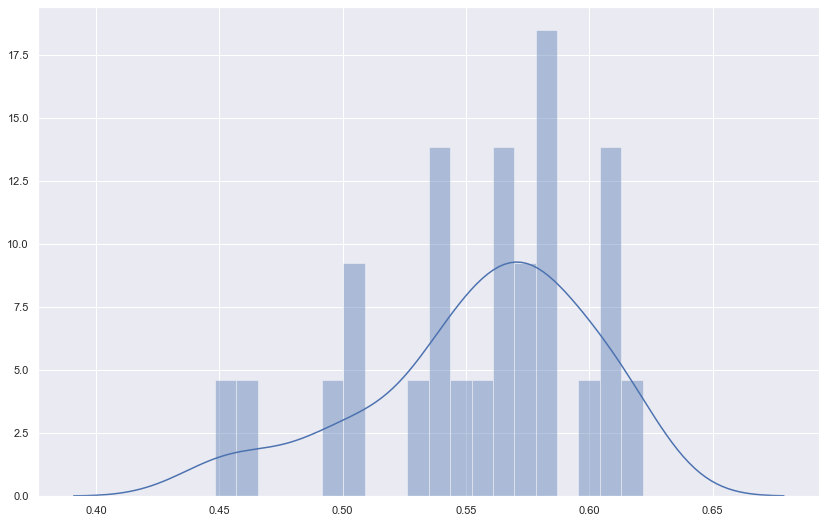

In [24]:
from sklearn.model_selection import KFold
from statistics import mean

kfold = KFold(n_splits=25, shuffle=True)

outputs = []
for train_I, test_I in kfold.split(X):
    # train_I = [0, 1, 2, 3, 4, ..] : indices du train
    # test_I = [5000, 5001, 5002, ...] : indices du test
    
    # TODO : Sélectionner les bons indices
    X_train = X.iloc[train_I, :]
    X_test = X.iloc[test_I, :]
    y_train = y[train_I]
    y_test = y[test_I]

    # TODO : Entraîner un Random Forest à 50 estimateurs, de profondeur maximale 8 et avec min_samples_leaf=10
    rf = RandomForestClassifier(n_estimators=100, max_depth=12, min_samples_leaf=3)
    rf.fit(X_train, y_train)

    # TODO : En déduire les Y prédits et ajouter le score à la liste 'outputs'
    y_pred = rf.predict(X_test)
    score = f1_score(y_test, y_pred)
    outputs.append(score)
    
sns.distplot(outputs, bins=20)
outputs
mean(outputs)

Déduisons-en un intervalle de confiance empirique Bootstrap de seuil de confiance $95\%$.

In [25]:
# TODO : Déduire l'intervalle de confiance empirique
np.quantile(outputs, q=[0.025, 0.975])

array([0.45788177, 0.61475034])

In [26]:
q=[0.025, 0.975,2,78,8784,65,787,44,89,9,98,565,98,90]
q[::-2]

[90, 565, 9, 44, 65, 78, 0.975]

### Repeated $k$-Fold CV

[0.5718954248366014,
 0.5675213675213675,
 0.5551948051948052,
 0.5511811023622047,
 0.5358851674641147,
 0.6062717770034843,
 0.5198675496688742,
 0.5016393442622951,
 0.5664000000000001,
 0.5918057663125948,
 0.5977742448330684,
 0.540453074433657,
 0.5654952076677316,
 0.5436241610738254,
 0.5774193548387097,
 0.5288135593220339,
 0.559349593495935,
 0.5718849840255591,
 0.5633802816901408,
 0.5860927152317881,
 0.5214521452145213,
 0.5587301587301587,
 0.6048780487804879,
 0.5676126878130217,
 0.5211726384364821]

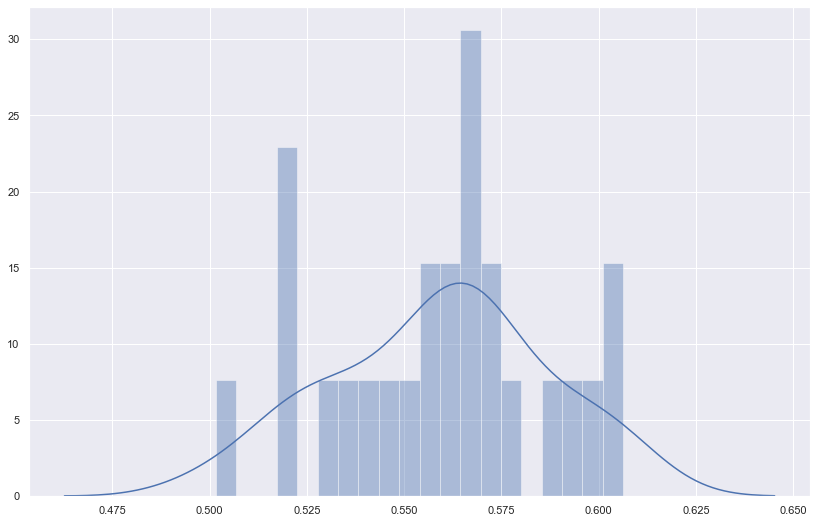

In [27]:
from sklearn.model_selection import RepeatedKFold

rep_kfold = RepeatedKFold(n_splits=5, n_repeats=5)

outputs = []
for train_I, test_I in rep_kfold.split(X):
    # TODO : Sélectionner les bons indices
    X_train = X.iloc[train_I, :]
    X_test = X.iloc[test_I, :]
    y_train = y[train_I]
    y_test = y[test_I]

    # TODO : Entraîner un Random Forest à 50 estimateurs, de profondeur maximale 8 et avec min_samples_leaf=10
    rf = RandomForestClassifier(n_estimators=100, max_depth=12, min_samples_leaf=3)
    rf.fit(X_train, y_train)

    # TODO : En déduire les Y prédits et ajouter le score à la liste 'outputs'
    y_pred = rf.predict(X_test)
    score = f1_score(y_test, y_pred)
    outputs.append(score)

    
sns.distplot(outputs, bins=20)
outputs

In [28]:
np.array(outputs).shape

(25,)

In [29]:
# TODO : Déduire l'intervalle de confiance empirique
np.quantile(outputs, q=[0.025, 0.975])

array([0.51257627, 0.60543554])

### Stratified $k$-Fold CV

Dans la méthode **Stratified** $k$**-Fold Cross-Validation**, c'est au Data Scientist de déterminer des groupes d'observations afin de produire un $k$-Fold sur chacun des groupes. Par exemple, s'il y a $3$ groupes identifiés, alors un $10$-Fold produira $30$ itérations.

<center><img src="data/005.png" style="max-width: 600px;" /></center>

### Leave-One-Out CV

La méthode **Leave-One-Out Cross-Validation** est un cas particulier du $k$-Fold CV où $k=n$. À chaque itération, le modèle est entraîné sur $n-1$ observations, puis le score est calculé sur la $n$-ème observation restante. Ce processus est ainsi répété $n$ fois pour parcourir toutes les observations.

<center><img src="data/003.png" style="max-width: 600px;margin:30px;" /></center>

En théorie rien n'oblige, dans le cas d'un $k$-Fold CV, un jeu d'entraînement à contenir un sous-échantillon représentatif de la population étudiée.

Par exemple, considérons un sondage sur la population française avec plusieurs statuts (scolaire, étudiant, actif, retraité, ...). Il est possible, en choisissant un $k$ élevé, qu'il existe un ou plusieurs sous-échantillons n'ayant aucun étudiant, ou encore aucun retraité. Ainsi, un modèle serait entraîné avec une classe de la population manquante, et donc le score sur le groupe « restant » permettrait d'étudier la capacité du modèle à généraliser sur de nouvelles observations.

In [ ]:
from sklearn.model_selection import LeaveOneOut

loo = LeaveOneOut()

outputs = []
for train_I, test_I in loo.split(X):
    # TODO : Sélectionner les bons indices
    X_train = X.iloc[train_I, :]
    X_test = X.iloc[test_I, :]
    y_train = y[train_I]
    y_test = y[test_I]

    # TODO : Entraîner un Random Forest à 50 estimateurs, de profondeur maximale 8 et avec min_samples_leaf=10
    rf = RandomForestClassifier(n_estimators=100, max_depth=12, min_samples_leaf=3)
    rf.fit(X_train, y_train)

    # TODO : En déduire les Y prédits et ajouter le score à la liste 'outputs'
    y_pred = rf.predict(X_test)
    score = f1_score(y_test, y_pred)
    outputs.append(score)

    
sns.distplot(outputs, bins=20)

In [ ]:
# TODO : Déduire l'intervalle de confiance empirique


In [17]:
groups = np.argmax(X.iloc[:, -3:].values, axis=1) + 1


### Leave-One-Group-Out CV

La méthode **Leave-One-Group-Out Cross-Validation** consiste à réaliser un $k$-Fold CV dans lequel le sous-ensemble de test contient un seul et unique groupe de la population étudiée.

<center><img src="data/004.png" style="max-width: 600px;margin:30px;" /></center>

**Quelle est la différence avec un Stratified $k$-Fold ?**

In [30]:
# TODO : Effectuer un LOGOCV à trois groupes selon la nationalité
from sklearn.model_selection import LeaveOneGroupOut

groups = np.argmax(X.iloc[:, -3:].values, axis=1) + 1

logo = LeaveOneGroupOut()

outputs = []
for train_I, test_I in logo.split(X, y, groups):
    # TODO : Sélectionner les bons indices
    X_train = X.iloc[train_I, :]
    X_test = X.iloc[test_I, :]
    y_train = y[train_I]
    y_test = y[test_I]

    # TODO : Entraîner un Random Forest à 50 estimateurs, de profondeur maximale 8 et avec min_samples_leaf=10
    rf = RandomForestClassifier(n_estimators=100, max_depth=12, min_samples_leaf=3)
    rf.fit(X_train, y_train)

    # TODO : En déduire les Y prédits et ajouter le score à la liste 'outputs'
    y_pred = rf.predict(X_test)
    score = f1_score(y_test, y_pred)
    outputs.append(score)

    
outputs

[0.5008460236886633, 0.45555555555555555, 0.482084690553746]

In [32]:
groups = np.argmax(X.iloc[:, -3:].values, axis=1) + 1
groups

array([1, 3, 1, ..., 1, 2, 1], dtype=int64)

## Comparaison de modèles

In [27]:
from xgboost import XGBClassifier
from sklearn.model_selection import RepeatedKFold

# TODO : Effecuter un Repeated K-Fold entre les deux modèles Random Forest et XGBoost
rep_kfold = RepeatedKFold(n_splits=10, n_repeats=20)

# Contiendra les scores des deux modèles
scores_kfold = []
for train_I, test_I in kfold.split(X):
    # TODO : Sélectionner les bons indices
    X_train = X.iloc[train_I, :]
    X_test = X.iloc[test_I, :]
    y_train = y[train_I]
    y_test = y[test_I]
    
    # TODO : Entraîner un Random Forest à 50 estimateurs, de profondeur maximale 8 et avec min_samples_leaf=10
    rf = RandomForestClassifier(n_estimators=100, max_depth=12, min_samples_leaf=3)
    rf.fit(X_train, y_train)
    
    # TODO : Entraîner un XGBoost à 100 arbres, de profondeur maximale 4 et de taux d'apprentissage 0.1
    xgb = XGBClassifier(n_rounds=100, max_depth=4, learning_rate=0.1)
    xgb.fit(X_train, y_train)
    
    # TODO : En déduire les Y prédits du Random Forest et ajouter le score à la liste 'outputs_1'
    y_pred = rf.predict(X_test)
    score_1 = f1_score(y_test, y_pred)
    
    # TODO : En déduire les Y prédits du XGBoost et ajouter le score à la liste 'outputs_2'
    y_pred = xgb.predict(X_test)
    score_2 = f1_score(y_test, y_pred)
    
    scores_kfold.append([score_1, score_2])
    
scores_kfold = np.asarray(scores_kfold)
scores_kfold

[15:45:19] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { n_rounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:45:21] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { n_rounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:45:23] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { n_rounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindi

[15:46:07] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { n_rounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:46:09] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { n_rounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[15:46:11] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.1.0\src\learner.cc:480: 
Parameters: { n_rounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindi

array([[0.57142857, 0.59259259],
       [0.53448276, 0.54700855],
       [0.57657658, 0.55462185],
       [0.56953642, 0.62025316],
       [0.55238095, 0.56074766],
       [0.5648855 , 0.57575758],
       [0.57627119, 0.5982906 ],
       [0.48739496, 0.53225806],
       [0.52542373, 0.52892562],
       [0.609375  , 0.59090909],
       [0.57142857, 0.56666667],
       [0.55882353, 0.53731343],
       [0.5248227 , 0.61111111],
       [0.62711864, 0.56666667],
       [0.49541284, 0.52252252],
       [0.58015267, 0.59854015],
       [0.52459016, 0.51968504],
       [0.58394161, 0.60431655],
       [0.54700855, 0.52892562],
       [0.65151515, 0.66176471],
       [0.65      , 0.671875  ],
       [0.50420168, 0.48333333],
       [0.49612403, 0.52941176],
       [0.58646617, 0.60150376],
       [0.57575758, 0.58394161]])

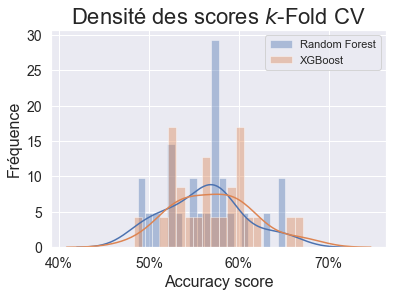

In [28]:
from matplotlib.ticker import FuncFormatter

sns.distplot(scores_kfold[:, 0], hist=True, bins=20, label="Random Forest")
sns.distplot(scores_kfold[:, 1], hist=True, bins=20, label="XGBoost")
ax = plt.gca()
ax.set_xlabel('Accuracy score',fontsize=16)
ax.set_ylabel('Fréquence',fontsize=16)
ax.xaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
ax.tick_params(axis="x", labelsize=14)
ax.tick_params(axis="y", labelsize=14)
plt.title("Densité des scores $k$-Fold CV", fontsize=22)
plt.legend()
plt.show()

### Test de Wilcoxon

In [31]:
from scipy.stats import wilcoxon

# TODO : Utiliser le test des rangs signés de Wilcoxon
wilcoxon(scores_kfold[:, 0], scores_kfold[:, 1])

WilcoxonResult(statistic=18.0, pvalue=0.00010105333347050026)

**Que pouvez-vous en déduire ?**